In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [98]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [99]:
# Select power data set
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
y_train_update=complete_ts[1:]

In [100]:
# Select forecast data set
x_train_update = x_train[x_train.hors==6]
x_train_update.index = pd.to_datetime(x_train_update.index, format= '%Y%m%d%H')
x_train_update = x_train_update[:'2010-12-31 12']
x_train_update['time'] = x_train_update.index + pd.to_timedelta(x_train_update.hors,"H")

# Normalize
maxi = x_train_update.ws.max()
mini = x_train_update.ws.min()
x_train_update.ws = (x_train_update.ws - mini)/(maxi-mini)

In [101]:
# One hot encode the wind directions
wd_onehot = []

for i in range(len(x_train_update)):
  onehot = 12*[None]
  sector = np.floor(x_train_update.wd[i]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd_onehot.append(onehot)

In [102]:
x_train_sectors = pd.DataFrame(np.concatenate((np.reshape(x_train_update.ws.values,(len(x_train_update),1)),
                                               wd_onehot,
                                               np.cos(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                               np.sin(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                               np.cos(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365),
                                               np.sin(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365)),
                                              axis = 1),
             columns = 'ws s1 s2 s3 s4 s5 s6 s7 s8 s9 s10 s11 s12 time_day_cos time_day_sin time_year_cos time_year_sin'.split())
x_train_sectors.drop('s12',axis=1, inplace=True)

In [103]:
print(np.shape(x_train_sectors))

(1098, 16)


In [104]:
# FFNN Day Ahead
# Define the FFNN network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # input 
        self.inputLay = nn.Linear(in_features = 16,
                               out_features = 128,
                               bias = True)
        self.hidden_layer = nn.Linear(in_features = 128,
                                      out_features = 128,
                                      bias = True)
        self.hidden_layer2 = nn.Linear(in_features = 128,
                              out_features = 128,
                              bias = True)
        self.output = nn.Linear(in_features = 128,
                               out_features = 1,
                               bias = True)

    def forward(self, x):
      x = self.inputLay(x)
      x = F.elu(x) # F = nn.Functional
      # x = self.hidden_layer(x)
      # x = F.elu(x)
      x = self.hidden_layer2(x)
      x = F.elu(x)
      out = self.output(x)

      return out



In [105]:
FFNN_mapping = Net()
print(FFNN_mapping)

Net(
  (inputLay): Linear(in_features=16, out_features=128, bias=True)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [106]:
# Test the FFNN
FFNN_mapping(   torch.Tensor(np.array([x_train_sectors.iloc[0:1]]))    )

tensor([[[0.1139]]], grad_fn=<AddBackward0>)

In [107]:
# Set the parameters for training

FFNN_mapping = Net()
# Convert to cuda if GPU available
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    FFNN_mapping.cuda()

# Define loss function and train parameters
criterion = nn.MSELoss()   
criterion2 = nn.L1Loss() 

# Adam gradient descent with learning rate decay
optimizer = optim.Adam(FFNN_mapping.parameters(), lr=5e-4)

# Length of the training and batches
epochs = 1000
batch_size = 8
num_batch = len(x_train_sectors)//batch_size

# Function to get the batch
get_batch = lambda i, size: range(i * size, (i + 1) * size)

# Track loss
training_RMSE = []
training_MAE = []


In [108]:
# Training

# Loop over epochs
for i in range(epochs):

    epoch_training_loss = 0
    epoch_training_loss2 = 0

    FFNN_mapping.train()

    # For each sequence in training set
    for b in range(num_batch):

      batch_index = get_batch(b,batch_size)
                 
      # Get inputs and targets
      inputs = torch.Tensor([np.array(x_train_sectors)[batch_index]]) # wind speed
      targets = torch.Tensor(np.array(y_train_update.wp1)[batch_index])  # power

      # Convert to cuda to run on GPU
      if torch.cuda.is_available():
            inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

      # Forward pass
      outputs = FFNN_mapping(inputs)
          
      # Compute loss
      loss = criterion(outputs, targets)
      loss2 = criterion2(outputs, targets)
          
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
          
      # Update loss
      if torch.cuda.is_available():
        epoch_training_loss += loss.cpu().detach().numpy()
        epoch_training_loss2 += loss2.cpu().detach().numpy()
      else:
        epoch_training_loss += loss.detach().numpy()
        epoch_training_loss2 += loss2.detach().numpy()

    
    # Save loss for plot
    epoch_RMSE = np.sqrt(epoch_training_loss/(num_batch))
    epoch_MAE = epoch_training_loss2/num_batch
    training_RMSE.append(epoch_RMSE)
    training_MAE.append(epoch_MAE)

    # Compute confidence interval
    # CI = [norm.ppf(0.025)*training_RMSE[-1],norm.ppf(0.975)*training_RMSE[-1]]

    # Print loss every 10 epochs
    if i % 1 == 0:
        print('Epoch %d, training RMSE: %.3f, training MAE: %.3f' % (i+1,training_RMSE[-1],training_MAE[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1, training RMSE: 0.185, training MAE: 0.137
Epoch 2, training RMSE: 0.180, training MAE: 0.134
Epoch 3, training RMSE: 0.180, training MAE: 0.133
Epoch 4, training RMSE: 0.180, training MAE: 0.136
Epoch 5, training RMSE: 0.179, training MAE: 0.134
Epoch 6, training RMSE: 0.176, training MAE: 0.134
Epoch 7, training RMSE: 0.174, training MAE: 0.133
Epoch 8, training RMSE: 0.174, training MAE: 0.133
Epoch 9, training RMSE: 0.173, training MAE: 0.133
Epoch 10, training RMSE: 0.173, training MAE: 0.133
Epoch 11, training RMSE: 0.173, training MAE: 0.133
Epoch 12, training RMSE: 0.172, training MAE: 0.132
Epoch 13, training RMSE: 0.172, training MAE: 0.132
Epoch 14, training RMSE: 0.172, training MAE: 0.132
Epoch 15, training RMSE: 0.172, training MAE: 0.132
Epoch 16, training RMSE: 0.171, training MAE: 0.132
Epoch 17, training RMSE: 0.171, training MAE: 0.132
Epoch 18, training RMSE: 0.171, training MAE: 0.131
Epoch 19, training RMSE: 0.171, training MAE: 0.131
Epoch 20, training RM

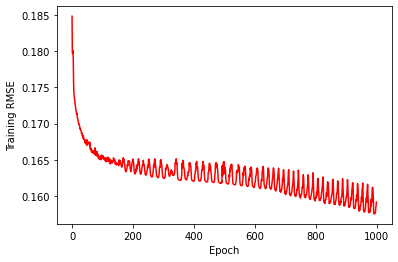

In [109]:
# Plot training loss
epoch = np.arange(len(training_RMSE))
plt.figure()
plt.plot(epoch, training_RMSE, 'r')
plt.xlabel('Epoch'), plt.ylabel('Training RMSE')
plt.show()